In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install geopandas
! pip install rasterio
! pip install rasterstats
! pip install --quiet contextily matplotlib
#! pip install torch 
# pip install earthpy
#! pip install gdal 
#! pip install cupy-cuda111     #>=7.7.0,<8.0.0'
#! pip install torchfcn
#! pip install pyyaml h5py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 71.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 20.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fiona
    Found existing installation: Fiona 1.9.4.post1
    Uninstalling Fiona-1.9.4.post1:
      Successfully uninstalled Fiona-1.9.4.post1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5

In [3]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import contextily as ctx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

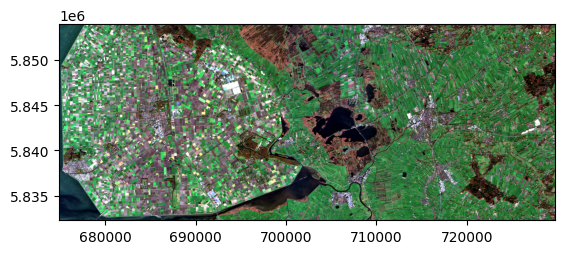

In [4]:
sat_img_path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/Data/sentinel2_2018_flevopolder_10m_7x4bands.tif"
def pct_clip(array,pct=[2,98]):
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip

bands = 28

with rasterio.open(sat_img_path,crs='EPSG:3857') as src:
    with rasterio.open(
            'RGB_NIR.tif', 'w+',
            driver='GTiff',
            dtype= rasterio.float32,
            count=bands,
            crs= rasterio.crs.CRS.from_epsg(3857),
            width=src.width,
            height=src.height,
            transform=src.transform,
        ) as dst:
        for i in range(1,bands+1,4):
          V = pct_clip(src.read(i+3)) #NIR
          dst.write(V,i+3)
          V = pct_clip(src.read(i+2)) #R
          dst.write(V,i)
          V = pct_clip(src.read(i+1)) #G
          dst.write(V,i+1)
          V = pct_clip(src.read(i))   #B
          dst.write(V,i+2)
        dst.close()

fig,ax=plt.subplots()
with rasterio.open("RGB_NIR.tif") as src2:
    show(src2.read([25,26,27]),transform=src2.transform,ax=ax)

In [5]:
parcel_shapefile_path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/Data/Flevopolder_2018_parcels_regionally/Flevopolder_Parcels_SplitRegionally.shp"
parcels = gpd.read_file(parcel_shapefile_path)
sat_img_path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/Data/sentinel2_2018_flevopolder_10m_7x4bands.tif"
#sat_img = rasterio.open(sat_img_path,crs='EPSG:3857')
sat_img = rasterio.open("RGB_NIR.tif") #,crs='EPSG:32631')

Text(0.5, 1.0, 'flevopolder parcels dataset')

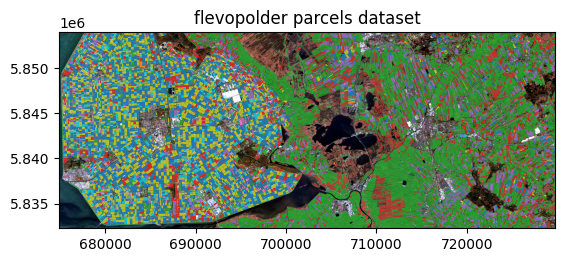

In [6]:
fig,ax = plt.subplots()#1,2,figsize=(24,12))
#ax = axs[0]
ax = show(sat_img.read([25,26,27]),transform=sat_img.transform,ax=ax)
ax.set_title("flevopolder satelite image")
#ctx.add_basemap(ax, crs='epsg:32631')
#ax = axs[1]
ax = parcels.to_crs(epsg=32631).plot(column="GWS_GEWAS", ax=ax, legend=False)
ax.set_title("flevopolder parcels dataset")
#ctx.add_basemap(ax, crs='epsg:32631')

In [7]:
parcels.head()

,OBJECTID,CAT_GEWASC,GWS_GEWASC,GEOMETRIE_,GEOMETRI_1,GWS_GEWAS,OBJECTID_2,REGION,Shape_Leng,Shape_Area,geometry
0,1526214.0,Bouwland,2015,583.773774,19567.658998,"Aardappelen, poot NAK",1526214.0,3,583.773723,19567.660222,"POLYGON ((173756.887 525021.120, 173756.815 52..."
1,1526369.0,Grasland,265,334.018326,2203.146610,"Grasland, blijvend",1526369.0,3,334.018337,2203.146813,"POLYGON ((194350.532 525167.317, 194346.564 52..."
2,1526370.0,Grasland,265,710.269508,4240.062968,"Grasland, blijvend",1526370.0,3,710.269550,4240.060234,"POLYGON ((194581.041 525183.137, 194574.426 52..."
3,1526371.0,Grasland,265,489.762016,9520.711108,"Grasland, blijvend",1526371.0,3,489.762016,9520.710080,"POLYGON ((194701.720 524314.531, 194574.058 52..."
4,1526388.0,Bouwland,259,1070.721971,27486.417515,"Maïs, snij-",1526388.0,3,1070.721971,27486.417515,"POLYGON ((208647.070 526451.009, 208592.990 52..."


In [8]:
#reclass parcels to 9 classes
classlist = []
classcodelist = []

#classify based on crop code, these can be added or changed if needed
for i in range(len(parcels)):
  GWS_code = parcels.loc[i,'GWS_GEWASC']
  if GWS_code == "265":
    Cropclass = "permanent meadows"
    classcode = 0
  elif GWS_code == "266":
    Cropclass = "temporary meadows"
    classcode = 1
  elif GWS_code == "235" or GWS_code =="236":
    Cropclass = "barley"
    classcode = 2
  elif GWS_code == "256" or GWS_code =="257":
    Cropclass = "beet"
    classcode = 3
  elif GWS_code == "814" or GWS_code =="316" or GWS_code =="317" or GWS_code =="259":
    Cropclass = "maize"
    classcode = 4
  elif GWS_code == "1001" or GWS_code =="1002" or GWS_code =="999" or GWS_code =="1004" or GWS_code =="998":
    Cropclass = "flowers"
    classcode = 5
  elif GWS_code == "2025" or GWS_code =="2017" or GWS_code =="2016" or GWS_code =="2015" or GWS_code =="2014":
    Cropclass = "potato"
    classcode = 6
  elif GWS_code == "1931" or GWS_code =="263" or GWS_code =="262":
    Cropclass = "union"
    classcode = 7
  elif GWS_code =="233" or GWS_code =="234":
    Cropclass = "wheat"
    classcode = 8
  elif GWS_code =="336" or GWS_code =="331" or GWS_code =="332":
    Cropclass = "grassland nature"
    classcode = 9
  elif GWS_code =="2787":
    Cropclass = "chicory"
    classcode = 10 
  elif GWS_code =="2785" or GWS_code =="2783" or GWS_code =="1036":
    Cropclass = "carrot"
    classcode = 11
  elif GWS_code =="1096" or GWS_code =="1098" or GWS_code =="1078" or GWS_code =="1077":
    Cropclass = "orchards"
    classcode = 12
  elif GWS_code =="258":
    Cropclass = "luzerne"
    classcode = 13
  elif GWS_code =="335":
    Cropclass = "nature and heather"
    classcode = 14
  elif GWS_code =="383":
    Cropclass = "grass seeds"
    classcode = 15
  elif GWS_code =="2797":
    Cropclass = "cauliflower"
    classcode = 16
  elif GWS_code =="2773" or GWS_code == "2774":
    Cropclass = "spinach"
    classcode = 17
  elif GWS_code =="2737" or GWS_code == "1922" or GWS_code =="1923":
    Cropclass = "rapeseed"
    classcode = 18
  elif GWS_code =="244":
    Cropclass = "peas"
    classcode = 19
  else:
    Cropclass = "other"
    classcode = 99
  classlist.append(Cropclass)
  classcodelist.append(classcode)

#drop Class column if code block runs for a second time
drop_classes = [
    "Class",
    "Classcode",
    "Shape_Leng",
    "Shape_Area",
    "OBJECTID_2",
    "GEOMETRIE_",
    "GEOMETRI_1"
]
for i in drop_classes:
  if i in parcels:
    parcels = parcels.drop(i,axis= "columns")


#insert Class column
parcels.insert(len(parcels.columns),'Class',classlist,True)
parcels.insert(len(parcels.columns),'Classcode',classcodelist,True)

#save selection of dataset
parcels_class = parcels[parcels["Class"]!= "other"].reset_index(drop=True)
parcels_class = parcels_class.loc[parcels_class['Classcode'].isin(range(20))]

#show the newly added column
parcels_class.head(10)

,OBJECTID,CAT_GEWASC,GWS_GEWASC,GWS_GEWAS,REGION,geometry,Class,Classcode
0,1526214.0,Bouwland,2015,"Aardappelen, poot NAK",3,"POLYGON ((173756.887 525021.120, 173756.815 52...",potato,6
1,1526369.0,Grasland,265,"Grasland, blijvend",3,"POLYGON ((194350.532 525167.317, 194346.564 52...",permanent meadows,0
2,1526370.0,Grasland,265,"Grasland, blijvend",3,"POLYGON ((194581.041 525183.137, 194574.426 52...",permanent meadows,0
3,1526371.0,Grasland,265,"Grasland, blijvend",3,"POLYGON ((194701.720 524314.531, 194574.058 52...",permanent meadows,0
4,1526388.0,Bouwland,259,"Maïs, snij-",3,"POLYGON ((208647.070 526451.009, 208592.990 52...",maize,4
5,1526456.0,Grasland,265,"Grasland, blijvend",4,"POLYGON ((179399.401 531024.745, 179398.208 53...",permanent meadows,0
6,1526457.0,Bouwland,262,"Uien, zaai-",4,"POLYGON ((180572.893 530484.068, 180571.448 53...",union,7
7,1526495.0,Bouwland,233,"Tarwe, winter-",3,"POLYGON ((184164.687 525545.153, 184064.071 52...",wheat,8
8,1526504.0,Bouwland,233,"Tarwe, winter-",1,"POLYGON ((182561.417 515412.945, 182561.417 51...",wheat,8
9,1526505.0,Bouwland,2787,"Witlofwortel, productie",1,"POLYGON ((183150.648 517375.969, 183150.648 51...",chicory,10


Text(0.5, 1.0, 'Regions')

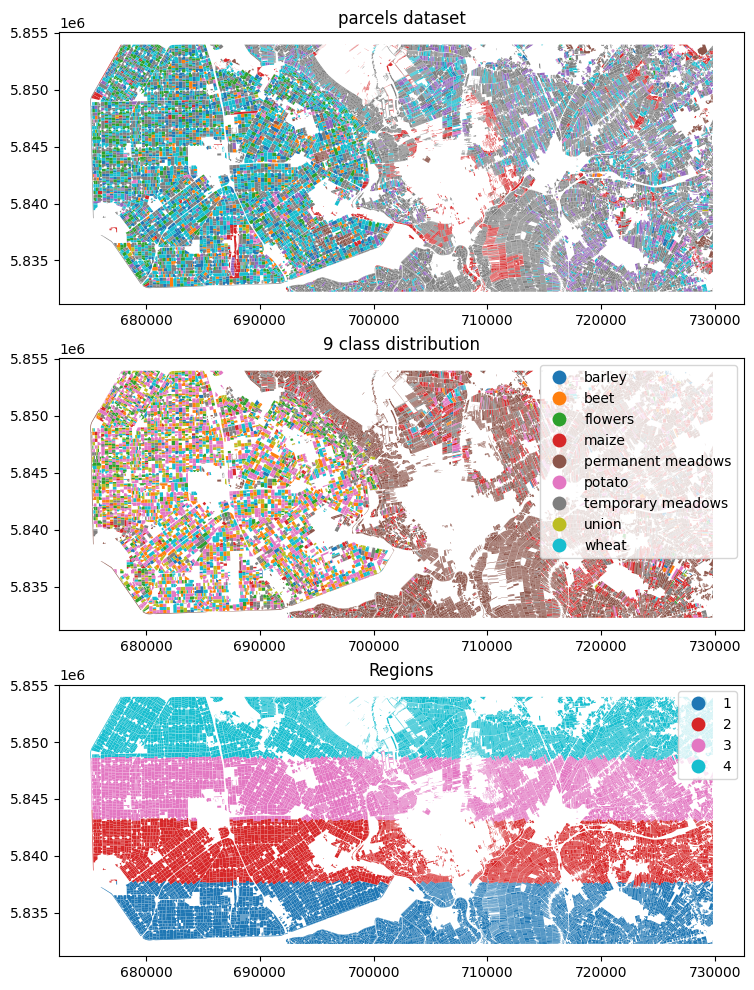

In [9]:
fig,axs = plt.subplots(3,1,figsize=(24,12))
ax = axs[0]
ax = parcels.to_crs(epsg=32631).plot(column="Class", ax=ax, legend=False)
ax.set_title("parcels dataset")
ax = axs[1]
ax = parcels_class.loc[parcels_class['Classcode'].isin(range(9))].to_crs(epsg=32631).plot(column="Class", ax=ax, legend=True)
ax.set_title("9 class distribution")
ax = axs[2]
ax = parcels_class.loc[parcels_class['Classcode'].isin(range(20))].to_crs(epsg=32631).plot(column="REGION", ax=ax, legend=True)
ax.set_title("Regions")
#ctx.add_basemap(ax, crs='epsg:32631')

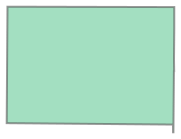

In [ ]:
parcels_class.loc[0,'geometry']

In [ ]:
# calculate zonal statistics of each polygon
# taking the mean value of all pixels underneath a polygon
parcels_class = parcels_class.to_crs(epsg=32631)

mean_df = pd.DataFrame()
meanmedian_df = pd.DataFrame()
meanmedianpercentile_df = pd.DataFrame()
meanlist= np.zeros((len(parcels_class),28))

for i in tqdm(range(28)): # read all pictures 7 time spans for 4 bands shoould be 28 but chan be changed to factors of 4 to read less time spans
  array = sat_img.read(i+1)
  affine = sat_img.transform
  print(i)
  meanlist = []
  medianlist = []
  perc_20list = []
  perc_80list = []
  for j in tqdm(range(len(parcels_class))): #calculate the mean pixel value on each band
    parcel = parcels_class.loc[j,'geometry']
    stats = zonal_stats(parcel, array, affine=affine, stats=['mean','median','percentile_20','percentile_80'])
    meanlist.append(stats[0]['mean'])
    medianlist.append(stats[0]['median'])
    perc_20list.append(stats[0]['percentile_20'])
    perc_80list.append(stats[0]['percentile_80'])

  stats_df = pd.DataFrame([meanlist,medianlist,perc_20list,perc_80list],["mean_"+str(i),"median_"+str(i),"p20_"+str(i),"p80_"+str(i)]).T

  mean_df = pd.concat([mean_df, stats_df.iloc[:,:1]],axis=1)
  meanmedian_df = pd.concat([meanmedian_df,stats_df.iloc[:,:2]],axis=1)
  meanmedianpercentile_df = pd.concat([meanmedianpercentile_df,stats_df],axis=1)

  stats_df = pd.DataFrame()


# outputs a table of all mean values having 28 colums, 1 for each band 
mean_df = pd.concat([parcels_class, mean_df],axis=1)
meanmedian_df = pd.concat([parcels_class, meanmedian_df],axis=1)
meanmedianpercentile_df = pd.concat([parcels_class, meanmedianpercentile_df],axis=1)

  0%|          | 0/28 [00:00<?, ?it/s]

0


  0%|          | 0/26245 [00:00<?, ?it/s]

1


  0%|          | 0/26245 [00:00<?, ?it/s]

2


  0%|          | 0/26245 [00:00<?, ?it/s]

3


  0%|          | 0/26245 [00:00<?, ?it/s]

4


  0%|          | 0/26245 [00:00<?, ?it/s]

5


  0%|          | 0/26245 [00:00<?, ?it/s]

6


  0%|          | 0/26245 [00:00<?, ?it/s]

7


  0%|          | 0/26245 [00:00<?, ?it/s]

8


  0%|          | 0/26245 [00:00<?, ?it/s]

9


  0%|          | 0/26245 [00:00<?, ?it/s]

10


  0%|          | 0/26245 [00:00<?, ?it/s]

11


  0%|          | 0/26245 [00:00<?, ?it/s]

12


  0%|          | 0/26245 [00:00<?, ?it/s]

13


  0%|          | 0/26245 [00:00<?, ?it/s]

14


  0%|          | 0/26245 [00:00<?, ?it/s]

15


  0%|          | 0/26245 [00:00<?, ?it/s]

16


  0%|          | 0/26245 [00:00<?, ?it/s]

17


  0%|          | 0/26245 [00:00<?, ?it/s]

18


  0%|          | 0/26245 [00:00<?, ?it/s]

19


  0%|          | 0/26245 [00:00<?, ?it/s]

20


  0%|          | 0/26245 [00:00<?, ?it/s]

21


  0%|          | 0/26245 [00:00<?, ?it/s]

22


  0%|          | 0/26245 [00:00<?, ?it/s]

23


  0%|          | 0/26245 [00:00<?, ?it/s]

24


  0%|          | 0/26245 [00:00<?, ?it/s]

25


  0%|          | 0/26245 [00:00<?, ?it/s]

26


  0%|          | 0/26245 [00:00<?, ?it/s]

27


  0%|          | 0/26245 [00:00<?, ?it/s]

In [ ]:
# save the complete dataframe to csv 
save_path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/Data/"
file_ext = ".csv"
    
mean_df.to_csv(save_path+"mean_df"+file_ext)
meanmedian_df.to_csv(save_path+"meanmedian_df"+file_ext)
meanmedianpercentile_df.to_csv(save_path+"meanmedianpercentile_df"+file_ext)

In [5]:
save_path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/Data/"
file_ext = ".csv"


pddf = pd.read_csv(save_path+"meanmedianpercentile_df"+file_ext)

,Unnamed: 0,OBJECTID,CAT_GEWASC,GWS_GEWASC,GWS_GEWAS,REGION,geometry,Class,Classcode,mean_0,...,p20_25,p80_25,mean_26,median_26,p20_26,p80_26,mean_27,median_27,p20_27,p80_27
0,0,1526214.0,Bouwland,2015,"Aardappelen, poot NAK",3,"POLYGON ((680002.7267884813 5843593.804429414,...",potato,6,0.426581,...,0.494749,0.551225,0.321988,0.296417,0.265472,0.364821,0.891915,0.982829,0.680104,1.000000
1,1,1526369.0,Grasland,265,"Grasland, blijvend",3,"POLYGON ((700582.3563919135 5844423.179694572,...",permanent meadows,0,0.143016,...,0.243174,0.476313,0.309871,0.325733,0.187296,0.416938,0.418359,0.414334,0.352968,0.489212
2,2,1526370.0,Grasland,265,"Grasland, blijvend",3,"POLYGON ((700812.2471921787 5844446.644352302,...",permanent meadows,0,0.136969,...,0.479813,0.551692,0.302288,0.296417,0.236156,0.352769,0.776314,0.783501,0.710116,0.862187
3,3,1526371.0,Grasland,265,"Grasland, blijvend",3,"POLYGON ((700961.7049947802 5843582.38934104, ...",permanent meadows,0,0.120967,...,0.224271,0.482614,0.216945,0.229642,0.136808,0.288274,0.524114,0.543673,0.376932,0.665920
4,4,1526388.0,Bouwland,259,"Maïs, snij-",3,"POLYGON ((714830.9952126411 5846181.032044981,...",maize,4,0.117513,...,0.347725,0.464177,0.442293,0.434853,0.356678,0.525733,0.242619,0.233669,0.202090,0.272938
5,5,1526456.0,Grasland,265,"Grasland, blijvend",4,"POLYGON ((685443.3210845608 5849781.776152125,...",permanent meadows,0,0.089980,...,0.040607,0.280047,0.096634,0.076547,0.000000,0.218893,0.214086,0.209406,0.147406,0.272340
6,6,1526457.0,Bouwland,262,"Uien, zaai-",4,"POLYGON ((686634.2118835734 5849280.309002638,...",union,7,0.437346,...,0.318553,0.376896,0.259571,0.260586,0.210098,0.302932,0.336438,0.328854,0.314296,0.346398
7,7,1526495.0,Bouwland,233,"Tarwe, winter-",3,"POLYGON ((690388.2816576688 5844462.848789425,...",wheat,8,0.521618,...,0.423571,0.491249,0.530678,0.530945,0.491857,0.576547,0.161297,0.159388,0.153042,0.165920
8,8,1526504.0,Bouwland,233,"Tarwe, winter-",1,"POLYGON ((689121.675253382 5834281.975520984, ...",wheat,8,0.437032,...,0.515753,0.602100,0.283964,0.273616,0.223127,0.344625,0.567639,0.583427,0.533035,0.630310
9,9,1526505.0,Bouwland,2787,"Witlofwortel, productie",1,"POLYGON ((689645.5938104304 5836263.658506297,...",chicory,10,0.632132,...,0.605834,0.731389,0.473776,0.465798,0.410423,0.544625,0.554764,0.468645,0.363568,0.809481


In [20]:

for i in range(20):

  x, y = pddf.loc[pddf['Classcode'].isin([i])].loc[pddf['REGION'].isin([4])].shape
  print(x)

2964
886
110
190
736
205
613
210
131
380
81
28
9
1
33
9
4
3
10
1
